In [9]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from IPython.display import display 
import model_utils
import data_utils as data_utils
# Pretty display for notebooks
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

dataset = pd.read_csv("datasets/dataset_validation.csv")


In [10]:
from __future__ import division
# TODO: Total number of records
n_records = dataset['RIESGO_VIDA'].count()

# TODO: Number of records where individual's life is at risk
life_risk = dataset[dataset["RIESGO_VIDA"] == 1]
n_life_risk = life_risk['RIESGO_VIDA'].count()

# TODO: Number of records where individual's life is not at risk
no_life_risk =  dataset[dataset["RIESGO_VIDA"] == 0]
n_no_life_risk = no_life_risk['RIESGO_VIDA'].count()

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = (n_life_risk/n_records)*100

# Print the results
print "Total number of records: {:,}".format(n_records)
print "Individuals with life at risk: {:,}".format(n_life_risk)
print "Individuals with life not at risk: {:,}".format(n_no_life_risk)
print "Percentage of individuals with life at risk: {:.2f}%".format(greater_percent)

Total number of records: 118,769
Individuals with life at risk: 14,355
Individuals with life not at risk: 104,414
Percentage of individuals with life at risk: 12.09%


In [24]:
import keras.backend as K

def precision(y_true, y_pred):
    """
    Precision metric.
     Only computes a batch-wise average of precision.
     Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """
    Recall metric.
     Only computes a batch-wise average of recall.
     Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1000):
    """Computes the F score.
     The F score is the weighted harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.
     This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
     With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    """
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
     # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

In [25]:
from keras.models import load_model

model = load_model('weights.best.from_scratch.hdf5', custom_objects={'recall': recall})

In [26]:
import pandas as pd
import numpy as np
from keras.utils import to_categorical

dataset_validation = pd.read_csv("datasets/dataset_validation.csv")

labels_validation = dataset_validation[['RIESGO_VIDA']].values
features_validation = dataset_validation.drop(['RIESGO_VIDA'], axis = 1).values

print(features_validation.shape)

X_validation = np.asarray(list(map(lambda row: row.reshape(7,5,1), features_validation)))
y_validation = to_categorical(labels_validation, 2)

evaluate = model.evaluate(X_validation, y_validation)
print(model.metrics_names)
print(evaluate)

(118769, 35)
118769/118769 [==============================] - 3s 22us/step
['loss', 'recall']
[0.24081305221218355, 0.886982293360382]


In [27]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)

for train_index, test_index in kf.split(X_validation):
    X_val = X_validation[train_index]
    y_val = y_validation[train_index]
    evaluate = model.evaluate(X_val, y_val)
    print(evaluate)


106892/106892 [==============================] - 2s 22us/step
[0.24035128260967648, 0.8874564981454326]
106892/106892 [==============================] - 2s 20us/step
[0.24092668076878923, 0.8871103543741494]
106892/106892 [==============================] - 2s 20us/step
[0.24061794020911648, 0.8870261572405941]
106892/106892 [==============================] - 2s 21us/step
[0.24059735123739046, 0.8866893687063726]
106892/106892 [==============================] - 2s 23us/step
[0.24099408043665216, 0.8870542229517792]
106892/106892 [==============================] - 2s 21us/step
[0.2409262335109072, 0.8870168020035324]
106892/106892 [==============================] - 2s 21us/step
[0.24014027073939787, 0.8875313400419262]
106892/106892 [==============================] - 2s 22us/step
[0.24043716649133387, 0.8872132619818283]
106892/106892 [==============================] - 2s 22us/step
[0.24139606112675124, 0.8864087115945214]
106893/106893 [==============================] - 2s 21us/step
[0.

[[0]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]
[0 0 0 ... 0 0 0]
tn: 101404.000000, fp: 3010.000000, fn:10413.000000, tp: 3942.000000
Confusion matrix, without normalization
[[101404   3010]
 [ 10413   3942]]


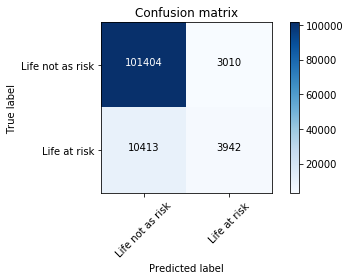

In [30]:
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical


y_predictions = model.predict_classes(X_validation)

print(labels_validation)
print(y_predictions)

cnf_matrix = confusion_matrix(labels_validation.flatten(), y_predictions)
tn, fp, fn, tp = confusion_matrix(labels_validation.flatten(), y_predictions).ravel()
print("tn: %f, fp: %f, fn:%f, tp: %f"%(tn, fp, fn, tp))
model_utils.plot_confusion_matrix(cnf_matrix, classes=['Life not as risk', 'Life at risk'], title='Confusion matrix')